[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Xiao-Chen820/AI-Driven-trend-and-Pattern-analysis-tool/blob/main/Tutorials/CoverageMap.ipynb)

************
 ### **Warm reminder**: This tutorial is developed based on the Count Map. Please check out the countmap.ipynb to look for more detailed explaination on mapping Ice Wedge Polygons at a tile level (BBOX). ###

 In this section, we will introduce how to create a coverage ratio map. However, we’re going to create an entire regional map at different resolutions, instead of a tile-level map consisting of fixed 256*256 pixels.
************

In [ ]:
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import psycopg2
from pyproj import Transformer
from shapely import geometry, wkt
import time
import pandas as pd
import geopandas as gpd
from shapely import geometry, wkt
from shapely.ops import transform
import matplotlib.pyplot as plt
import numpy as np

# 1. Database Connection #

We have three ways to connect to PostgreSQL:


1. Using **psql** (a terminal-based front-end to PostgreSQL)

2. Using **Pgadmin 4** (a a graphical user interface administration tool to manage PostgreSQL)

3. Using **psycopg2** (a python package to connect to PostgreSQL).

We will use psycopg2 to set up the connection.

In [ ]:
def set_up_connection(db_host, port, user, pwd, db):
    try:
        connection = psycopg2.connect(
        host=db_host,
        port=port,
        user=user,
        password=pwd,
        database=db,
        )
        # cursor = connection.cursor()
        print('Connection established successfully!')
        return connection
    except Exception as e:
        print("Error connecting to the database:", e)

# 2. Create pixels (1km * 1km) within ROI #
User may select a Region of Interest and wants to show the coverage ratio of polygons within 1km2 or smaller/larger area (which is defined as a pixel resolution in coverage ratio map), we will need a **rasterized polygon** with the pixel size of 1km2.

First, we will need to create a polygon as ROI with the given input of latitude and longitude extent. This is similar to create a BBOX


In [ ]:
def create_ROI(x1, y1, x2, y2):
    # x1: xmin, y1: ymin, x2: xmax, y2: ymax
    p1 = geometry.Point(x1, y1)
    p2 = geometry.Point(x1, y2)
    p3 = geometry.Point(x2, y2)
    p4 = geometry.Point(x2, y1)
    pointList = [p1, p2, p3, p4]
    poly = geometry.Polygon([[p.x, p.y] for p in pointList])
    print(poly)

    # Reproject the polygon to EPSG:3413
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3413", always_xy=True)
    reprojected_ROI = transform(transformer.transform, poly)
    print(f"The coordinates of reprojected ROI is: {reprojected_ROI}")
    return reprojected_ROI

Given the above user-defined ROI as polygon input, 1km2 as the pixel size.

In [ ]:
def rasterize_polygon(polygon, pixel_size, output_path):
    # Calculate the width and height of the raster in pixels
    xmin, ymin, xmax, ymax = polygon.bounds
    print(f"The polygon bounds of this ROI is: {xmin, ymin, xmax, ymax}")
    # polygon bounds is in meters, the pixel size is 1km x 1km
    print(f"The width size is: {xmax - xmin}")
    print(f"The height size is: {ymax - ymin}")
    # Calculate the width and height of the raster in pixels
    width = int((xmax - xmin) / pixel_size)
    height = int((ymax - ymin) / pixel_size)
    print(f"The height and width of this raster is: {height, width}")

    # Create an empty raster
    raster = rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=rasterio.uint8,
        crs='EPSG:3413',
        transform=from_origin(xmin, ymax, pixel_size, pixel_size)
    )
    raster.close()

    return raster, height, width

#3. Get the centroid points and calculate area sum within a pixel#

To get centroid points within a pixel, we will first iterate through the 2-D raster to get the bounding of each pixel, and set this bounding as BBOX used for querying data.

To query for data falls within the pixel, we will apply the same function (get centroids_within_bbox) as mentioned in CountMap.ipynb.

In [ ]:
def sql_to_geodataframe(query, conn):
   # crs: Coordinate reference system to use for the returned GeoDataFrame
   pd.set_option('display.max_colwidth', None)
   geo_df = gpd.read_postgis(query, conn, geom_col='geom_centroid', crs="3413")
   return geo_df

In [ ]:
def get_centroids_within_bbox(bbox, col_names, conn):
    query = "SELECT " + col_names + " FROM alaska_all_3413 polygons WHERE ST_within(polygons.geom_centroid, ST_GeomFromText('" + bbox + "', 3413))"
    geo_df = sql_to_geodataframe(query, conn)
    return geo_df

In [ ]:
# Optional
def statistics_histogram(output_file, output_path):
    with rasterio.open(output_file) as src:
        updated_raster = src.read(1)
        print(f"The updated raster is: {updated_raster}")
        # Mask the 0 values in the raster data
        masked_raster = np.ma.masked_equal(updated_raster, 0)

        # # Flatten the masked array and remove the masked elements
        data = masked_raster.compressed()

        # Calculate the overall statistics for all heatmaps
        overall_min = np.min(data)
        overall_max = np.max(data)
        overall_mean = np.mean(data)
        overall_std = np.std(data)

        # Print the overall statistics
        print("Overall Min:", overall_min)
        print("Overall Max:", overall_max)
        print("Overall Mean:", overall_mean)
        print("Overall Standard Deviation:", overall_std)

        # Plot histogram

        # Flatten the 2D array to 1D for histogram plotting
        flattened_raster = data.flatten()
        print(f"The flattened raster is: {flattened_raster}")

        # Plot histogram
        plt.hist(flattened_raster, bins=50, edgecolor='k', alpha=0.7)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title('Histogram of the raster (excluding 0 values)')
        plt.savefig(output_path)

In [ ]:
def write_tif_to_readable_file(tif_path, output_file_path):
    with rasterio.open(tif_path) as src:
        data = src.read(1)  # Read the first band
        with open(output_file_path, 'w') as f:
            for row in data:
                f.write(' '.join(map(str, row)) + '\n')

This rasterize_polygon function will return a raster consisting of height*width 1km2 pixels. The raster is actually an array. And then we will create a zero-like array called temp_raster in this case, same as this raster to store the area sum which will be used in the further steps.

We will calculate the area sum of all of the centroid points falling within this area.

In [ ]:
def draw_coverage_ratio(x1, y1, x2, y2, connection, column_names, rasterized_polygon_path, sum_raster_path, ratio_raster_path, figure_path, histogram_path, pixel_size):
    # Create a polygon from the ROI, 3413
    iwp_ROI = create_ROI(x1, y1, x2, y2)
    polygon_bounds = iwp_ROI.bounds
    print(f"The polygon is: {iwp_ROI}, the bounds of the polygon is: {polygon_bounds}")

    # Create a rasterized version of the polygon (ROI)
    original_raster, height, width = rasterize_polygon(iwp_ROI, pixel_size, rasterized_polygon_path)
    # Reopen the raster in read mode
    with rasterio.open(rasterized_polygon_path, 'r') as src:
        temp_raster = np.zeros_like(src.read(1), dtype=np.float32)

    # # rasterized_polygons is a ROI. This rasterized polygon will be separated into mutiple 1*1 km pixels
    # # Iterate over each cell in the raster
    start = time.time()
    for row in range(original_raster.shape[0]):
        for col in range(original_raster.shape[1]):
            # cell_centroid = rasterized_polygons.xy(row, col)
            # print(f"Cell ({row}, {col}) has the centroid: {cell_centroid}")

            # Calculate the bounding box of the cell
            xmin, ymin = rasterio.transform.xy(original_raster.transform, row, col, offset='ul')
            xmax, ymax = rasterio.transform.xy(original_raster.transform, row + 1, col + 1, offset='ul')
            cell_bounds = (xmin, ymin, xmax, ymax)
            # bounds_list.append(cell_bounds)
            print("-----------------------------------------")
            print(f"Cell ({row}, {col}) has the bounds: {cell_bounds}")

            # cell bounds to bounding box
            bbox = f"POLYGON(({xmin} {ymin}, {xmin} {ymax}, {xmax} {ymax}, {xmax} {ymin}, {xmin} {ymin}))"
            # Get the centroids and areas within the bounding box from database
            geodf = get_centroids_within_bbox(bbox, column_names, connection)
            iwp_count = len(geodf)
            print(f"The number of IWP within the bounding box is: {iwp_count}")
            coverage_sum = geodf['area'].sum()

            # Store the area sum in the new raster
            temp_raster[row, col] = coverage_sum
    end = time.time()
    print(f"The runtime of calculating coverage sum is {end - start}")

    # Save the updated raster array to a new file, so if we want to plot again we dont have to run the above query again
    create_area_sum_raster(original_raster, temp_raster, sum_raster_path)

    # Calculate the coverage ratio of the cell
    calculate_coverage_ratio(sum_raster_path, ratio_raster_path, pixel_size)

    # Plot the new raster
    plot_raster(ratio_raster_path, polygon_bounds, height, width, figure_path)
    statistics_histogram(ratio_raster_path, histogram_path)

# 4. Create an area sum raster #
Usually after we get the area sum results, we can write it into a tif file, and render the raster file based on the existing results. We don’t have to repeatedly take time to query once and once again, and re-render the raster result if the rendering effect will be changed in the future.

Given the rasterized polygon and all the area sum stored in the temp_raster array, we can create a new raster to store the area sum and write it into a raster file.

We will get coordinates, transform, as well as height and width information from the rasterized polygon, and get area sums from the array.


In [ ]:
def create_area_sum_raster(original_raster, updated_raster, output_file):
    with rasterio.open(
        output_file,
        'w',
        driver='GTiff',
        height=updated_raster.shape[0],
        width=updated_raster.shape[1],
        count=1,
        dtype=np.float32,
        crs=original_raster.crs,
        transform=original_raster.transform,
    ) as dst:
        dst.write(updated_raster, 1)
    return dst

# 5. Calculate coverage ratio based on the area sum raster at 1km2#

Given the area sum raster file, an output file path for coverage ratio raster, and resolution (1km2 in this case), we can calculate the coverage ratio raster, and write it into a raster file.

Sometimes, when we are using the centroids that falls within the pixel to represent all the polygon falls within too, this may cause some error, such as ratio > 1.  To avoid the issue of ratio larger than 1, we will rescale the ratio: If ratio > 1, we will assign the ratio = 1. If not, we will keep the original value.

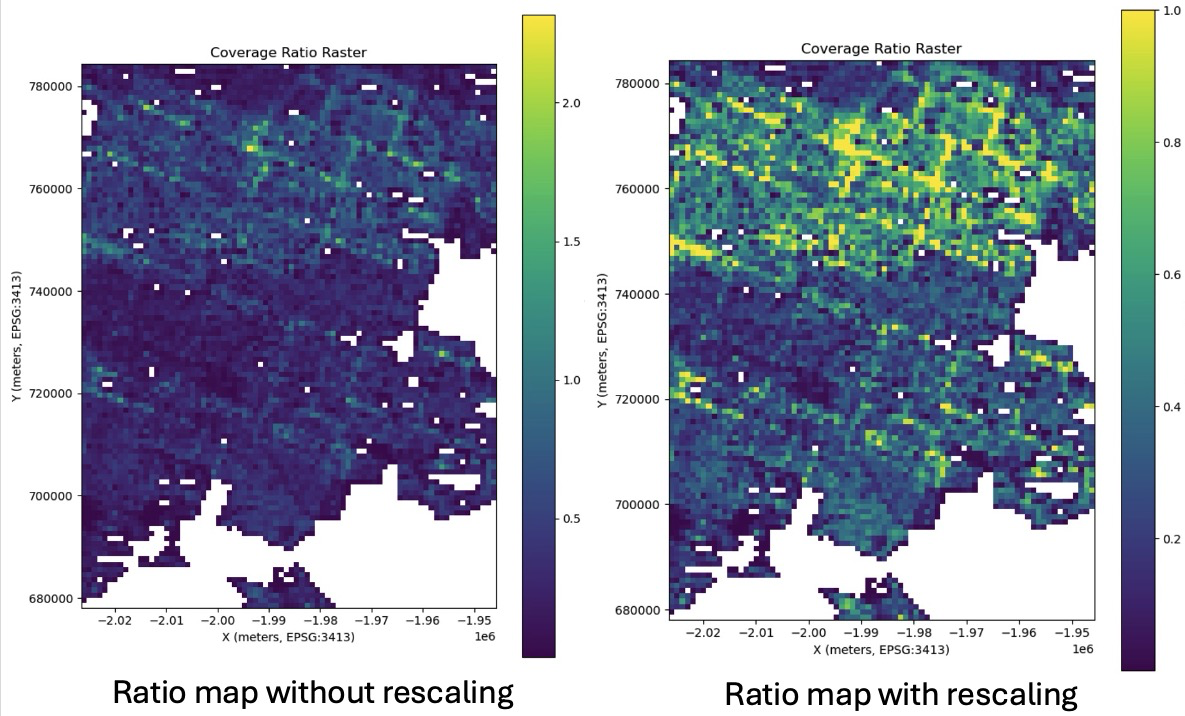

In [ ]:
def calculate_coverage_ratio(sum_tif_file, ratio_tif_file, resolution):
    with rasterio.open(sum_tif_file,'r',) as raster:
        sum_raster = raster.read(1)
        with rasterio.open(
                ratio_tif_file,
                'w',
                driver='GTiff',
                height=sum_raster.shape[0],
                width=sum_raster.shape[1],
                count=1,
                dtype=np.float32,
                crs=raster.crs,
                transform=raster.transform,
            ) as src:
                # Since ratio could not larger than 1, so if the area sum is larger than 1, we will assign 1 to this cell
                coverage_ratio_raster = np.minimum(sum_raster / (resolution * resolution), 1)
                print(f"The coverage ratio raster is: {coverage_ratio_raster}")
                src.write(coverage_ratio_raster, 1)
    return coverage_ratio_raster

# 6. Plot the coverage ratio map at 1km2 resolution #

Finally, we can plot out the coverage ratio. Here, we defined the plot height and width as 1/10 times of the raster height and width if the raster height and width is larger than 10.

Also, we will mask out all 0 values.


In [ ]:
def plot_raster(sum_tif_file, bounds, height, width, figure_path):
    # Read the raster data
    with rasterio.open(sum_tif_file) as src:
        updated_raster = src.read(1)

        plot_height = int(height/10) if height >100 else height
        plot_width = int(width/10) if width >100 else width
        print(f"The plot height and width is: {plot_height, plot_width}")

        extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
        print(f"The extent of the raster is: {extent}")

        # Create a masked array where 0 values are masked
        masked_raster = np.ma.masked_where(updated_raster == 0, updated_raster)

        # Plot the raster data with a color map
        plt.figure(figsize=(plot_width, plot_height))
        plt.title('Coverage Ratio Raster')
        plt.imshow(masked_raster, extent=extent, cmap='viridis')
        plt.colorbar(label='Coverage Ratio')
        plt.xlabel('X (meters, EPSG:3413)')
        plt.ylabel('Y (meters, EPSG:3413)')
        plt.savefig(figure_path)

    return 0

# 7. Draw a new coverage ratio map from tif #

## 7.1. Draw a new coverage ratio map from an existing tif and given extent ##

In [ ]:
def draw_coverage_ratio_from_tif(x1, y1, x2, y2, pixel_size, rasterized_polygon_path, sum_raster_path, ratio_raster_path, figure_path, histogram_path):
    # Create a polygon from the ROI, 3413
    iwp_ROI = create_ROI(x1, y1, x2, y2)
    polygon_bounds = iwp_ROI.bounds
    print(f"The polygon is: {iwp_ROI}, the bounds of the polygon is: {polygon_bounds}")

    # Create a rasterized version of the polygon (ROI)
    original_raster, height, width = rasterize_polygon(iwp_ROI, pixel_size, rasterized_polygon_path)
    # Reopen the raster in read mode
    with rasterio.open(rasterized_polygon_path, 'r') as src:
        temp_raster = np.zeros_like(src.read(1), dtype=np.float32)

    # Calculate the coverage ratio of the cell
    calculate_coverage_ratio(sum_raster_path, ratio_raster_path, pixel_size)

    # Plot the new raster
    plot_raster(ratio_raster_path, polygon_bounds, height, width, figure_path)
    statistics_histogram(ratio_raster_path, histogram_path)

## 7.2. Draw a coverage ratio map at different resolutions ##

After creating the area sum raster file at 1km2, we can create coverage ratio map at 2km2, 4km2, or even lower based on our needs. This will resample the original area sum raster.

In [ ]:
def resample_coverage_ratio_from_tif(pixel_size, sum_raster_path, ratio_raster_path, figure_path, histogram_path):
    # Reopen the raster in read mode
    with rasterio.open(sum_raster_path, 'r') as src:
        bounds = src.bounds
        print(f"The bounds of the ROI are: {bounds}")
        original_raster = src.read(1)
        original_transform = src.transform
        original_crs = src.crs

        # Calculate new dimensions
        stride = int(pixel_size / 1000)
        print(f"The stride is: {stride}")
        new_height = original_raster.shape[0] // stride
        new_width = original_raster.shape[1] // stride
        print(f"The original height and width are: {original_raster.shape[0], original_raster.shape[1]}")
        print(f"The new height and width are: {new_height, new_width}")

        # Calculate new transform
        # Return an Affine transformation for a georeferenced raster given the coordinates of its upper left corner west, north and pixel sizes xsize, ysize.
        new_transform = rasterio.transform.from_origin(
            original_transform.c, original_transform.f, pixel_size, pixel_size
        )

        # Resample the raster to the new resolution
        temp_raster = np.zeros((new_height, new_width), dtype=np.float32)
        for i in range(new_height):
            for j in range(new_width):
                temp_raster[i, j] = np.sum(
                    # if stride = 2, [0, 0] -> [0:2, 0:2], [1, 0] -> [2:4, 0:2], [0, 1] -> [0:2, 2:4], [1, 1] -> [2:4, 2:4]
                    # if stride = 3, [0, 0] -> [0:3, 0:3], [1, 0] -> [3:6, 0:3], [0, 1] -> [0:3, 3:6], [1, 1] -> [3:6, 3:6]
                    original_raster[i*stride:(i+1)*stride, j*stride:(j+1)*stride]
                )

        # Update the metadata
        meta = src.meta.copy()
        meta.update({
            "height": new_height,
            "width": new_width,
            "transform": new_transform,
            "dtype": np.float32
        })

        # Write the resampled raster to a new file
        resampled_sum_raster_path = sum_raster_path.replace("1km.tif", str(stride)+ "km.tif")
        with rasterio.open(resampled_sum_raster_path, 'w', **meta) as dst:
            dst.write(temp_raster, 1)
        temp_raster = np.zeros_like(src.read(1), dtype=np.float32)

    # Calculate the coverage ratio of the cell
    resample_ratio_raster_path = ratio_raster_path.replace("1km.tif", str(stride)+ "km.tif")
    calculate_coverage_ratio(resampled_sum_raster_path, resample_ratio_raster_path, pixel_size)

    # Plot the new raster
    resample_figure_path = figure_path.replace("1km.png", str(stride)+ "km.png")
    plot_raster(resample_ratio_raster_path, bounds, new_height, new_width, resample_figure_path)

    # Plot the histogram
    # resampled_histogram_path = histogram_path.replace("_1km.png", "_2km.png")
    # statistics_histogram(ratio_raster_path, resampled_histogram_path)

In [ ]:
if __name__=="__main__":
    hostname = "cici.lab.asu.edu"
    port = "5432"
    user = "postgres"
    password = "shirly"
    database = "postgres"

    column = ["gid", "class", "sensor", "date", "time", "image", "area", "centroidx", "centroidy", "permeter", "length", "width", "geom_centroid"]
    column_names = "area, geom_centroid"

    # First ROI
    # west = -159.36970
    # south = 70.69748
    # east = -155.08690
    # north = 71.37637

    # Second ROI
    west = -156.47441
    south = 70.40887
    east = -153.92505
    north = 70.87147

    # Third ROI
    # west = -158.98640
    # south = 70.43600
    # east = -152.21878
    # north = 70.81066

    # fourth ROI
    # west = -156.59837
    # south = 71.29713
    # east = -156.53562
    # north = 71.34686

    # fifth ROI: Northen Alaska
    # west = -163.43621
    # south = 69.15289
    # east = -141.14938
    # north = 71.34428

    resolution = 3000

    rasterized_polygon_path = "./rasters/ROI/ROI_v2_1km.tif"
    sum_raster_path = "./rasters/RasterTIF/coverage_sum_raster_v2_1km.tif"
    ratio_raster_path = "./rasters/RasterTIF/coverage_ratio_raster_v2_1km.tif"
    figure_path = "./rasters/RasterPNG/coverage_ratio_raster_v2_1km.png"
    histogram_path = "./rasters/histogram/histogram_v2_1km.png"
    array_path = "./rasters/RasterTXT/coverage_ratio_array_v2_1km.txt"

    connection = set_up_connection(hostname, port, user, password, database)
    # draw_coverage_ratio(west, south, east, north, connection, column_names, rasterized_polygon_path, sum_raster_path, ratio_raster_path, figure_path, histogram_path, resolution)
    # draw_coverage_ratio_from_tif(west, south, east, north, resolution, rasterized_polygon_path, sum_raster_path, ratio_raster_path, figure_path, histogram_path)
    resample_coverage_ratio_from_tif(resolution, sum_raster_path, ratio_raster_path, figure_path, histogram_path)
    # write_tif_to_readable_file(ratio_raster_path, array_path)